In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from benfordslaw import benfordslaw
bl = benfordslaw(verbose=0)

In [2]:
import requests

# Data downloaded as excel from https://chicagoelections.gov/en/election-results-specifics.asp
# and saved as csv to dataexport.csv

data = pd.read_csv('data/chicago_dataexport.csv', skiprows=10)
data = data.dropna()
data = data[~(data['Precinct'].isin(['Total', 'Precinct']))]

In [3]:
data.head()

,Precinct,Votes,Joseph R. Biden & Kamala D. Harris,%,Donald J. Trump & Michael R. Pence,%.1,Howie Hawkins & Angela Walker,%.2,Gloria La Riva & Leonard Peltier,%.3,Brian Carroll & Amar Patel,%.4,Jo Jorgensen & Jeremy ''Spike'' Cohen,%.5
0,1,645,553,85.74%,73,11.32%,7,1.09%,6,0.93%,1,0.16%,5,0.78%
1,2,519,459,88.44%,47,9.06%,5,0.96%,3,0.58%,0,0%,5,0.96%
2,3,664,591,89.01%,64,9.64%,1,0.15%,0,0%,1,0.15%,7,1.05%
3,4,659,561,85.13%,86,13.05%,3,0.46%,2,0.30%,0,0%,7,1.06%
4,5,625,548,87.68%,64,10.24%,3,0.48%,2,0.32%,0,0%,8,1.28%


In [4]:
data = data[['Joseph R. Biden & Kamala D. Harris ',
       'Donald J. Trump & Michael R. Pence ', 
       'Howie Hawkins & Angela Walker ', 
       'Gloria La Riva & Leonard Peltier ', 
       'Brian Carroll & Amar Patel ', 
       "Jo Jorgensen & Jeremy ''Spike'' Cohen "]]
data.head()

,Joseph R. Biden & Kamala D. Harris,Donald J. Trump & Michael R. Pence,Howie Hawkins & Angela Walker,Gloria La Riva & Leonard Peltier,Brian Carroll & Amar Patel,Jo Jorgensen & Jeremy ''Spike'' Cohen
0,553,73,7,6,1,5
1,459,47,5,3,0,5
2,591,64,1,0,1,7
3,561,86,3,2,0,7
4,548,64,3,2,0,8


In [5]:
unstacked_data = data.unstack().reset_index().rename(
    columns={0: 'count', 'level_0': 'candidate'})
unstacked_data = unstacked_data[['candidate', 'count']]
unstacked_data['count'] = unstacked_data['count'].astype(int)
unstacked_data = unstacked_data.reset_index()


In [6]:
unstacked_data.head()

,index,candidate,count
0,0,Joseph R. Biden & Kamala D. Harris,553
1,1,Joseph R. Biden & Kamala D. Harris,459
2,2,Joseph R. Biden & Kamala D. Harris,591
3,3,Joseph R. Biden & Kamala D. Harris,561
4,4,Joseph R. Biden & Kamala D. Harris,548


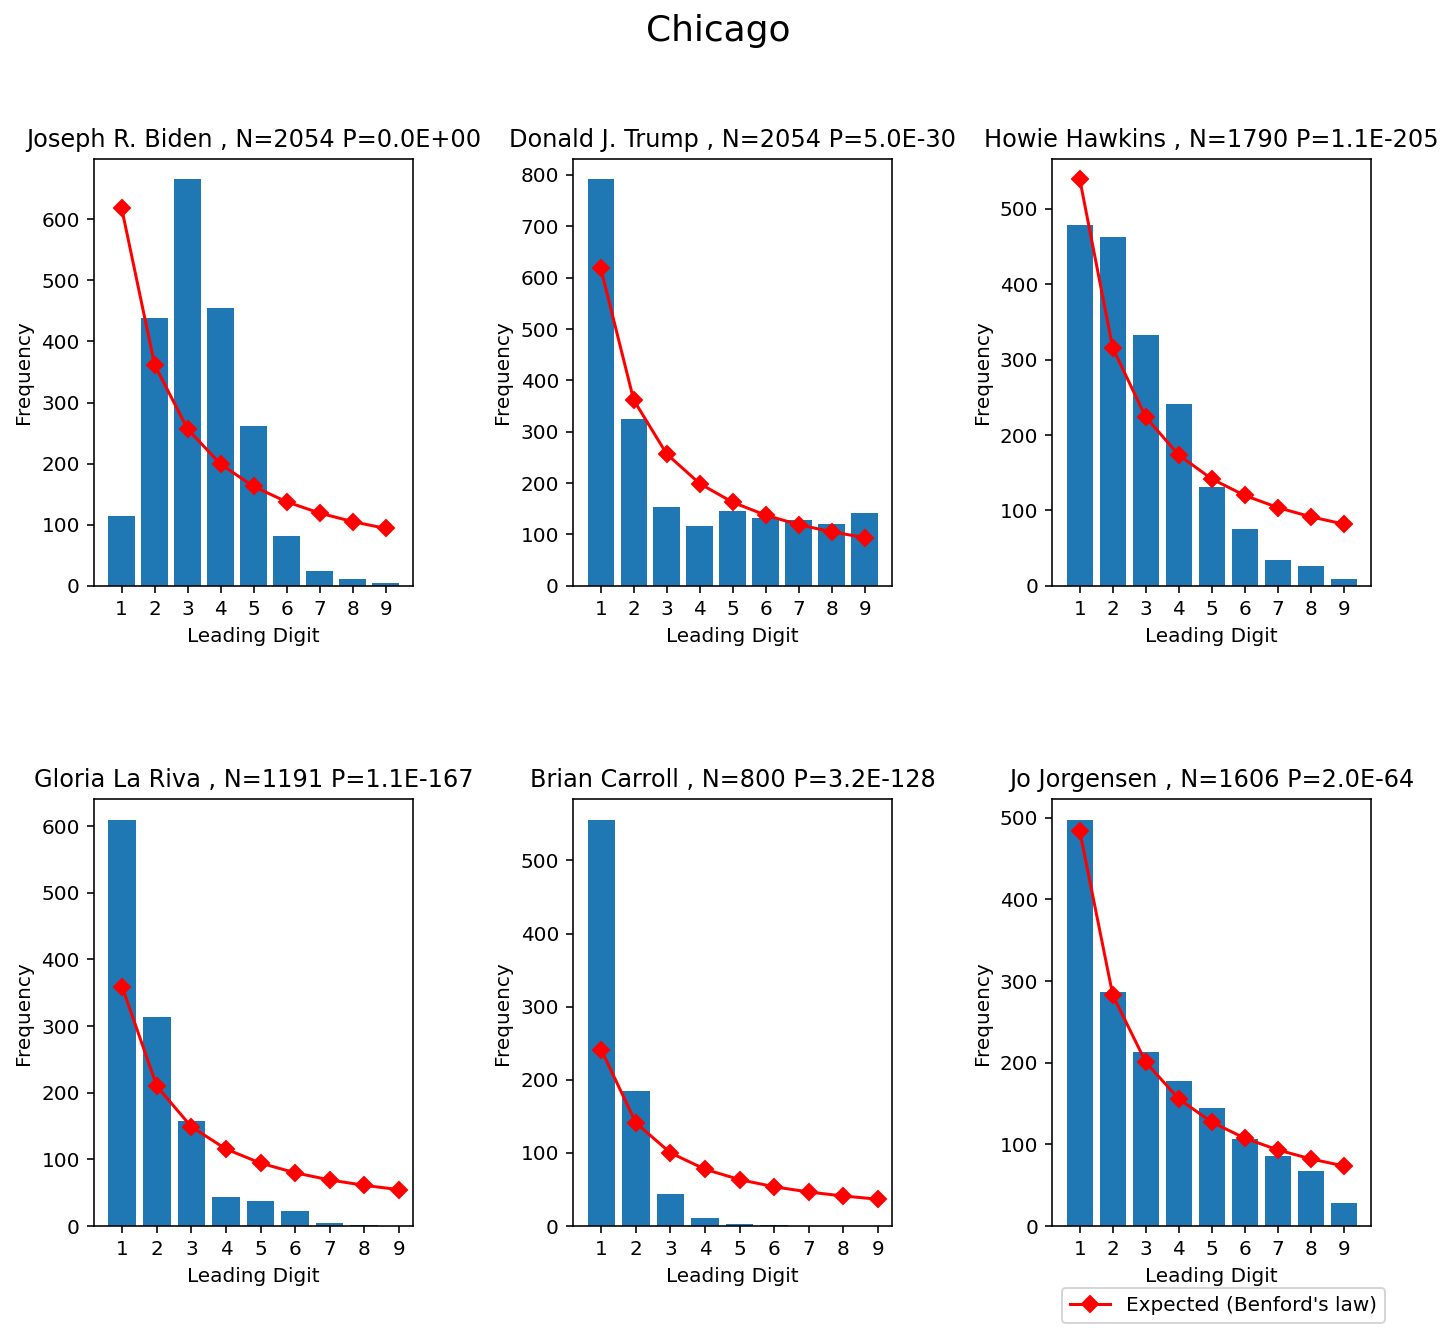

In [15]:

fig, axs = plt.subplots(2, 3, figsize=(12, 10))
fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])
plt.subplots_adjust(hspace=0.5, wspace=0.5)

axs = np.array(axs).flatten()
candidates = unstacked_data.candidate.unique()

# benford's law
digit = np.arange(1, 10)

for i in range(len(axs)):

    ax = axs[i]
    candidate = candidates[i]

    N = len(data[data[candidate].astype(int) > 0])
    expected = np.log10(1 + 1/digit)*N
    
    cur_data = unstacked_data
    cur_data = cur_data.groupby(['candidate', 'index']).sum()
    
    counts = cur_data.loc[candidate]['count']
    P = bl.fit(np.array(counts.astype(int).tolist()))['P']
    
    digits = counts.astype(str).str[0].astype(int)
    digits = digits[digits > 0]
    
    v = digits.value_counts()
    ax.bar(v.index, v.values)
    ax.set_xticks(range(1, 10))

    ax.plot(digit, expected, marker='D', color='red', label='Expected (Benford\'s law)')
    
    candidate_ = candidate.split('&')[0] # make the text show up correctly
    if P < .001:
        ax.set_title("%s, N=%d P=%.1E" % (candidate_, N,P))
    else:
        ax.set_title("%s, N=%d P=%0.3f" % (candidate_, N,P))
    
    ax.set_xlabel("Leading Digit")
    ax.set_ylabel("Frequency")

plt.legend(loc=3, bbox_to_anchor=(0.0, -0.25))
plt.suptitle("Chicago", fontsize=18)
plt.savefig('images/chicago.png')